<a href="https://colab.research.google.com/github/eutiagovski/data-science/blob/main/PRO5_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### OBJETIVO

* Aplicar o conhecimento adquirido em aula sobre Autoencoders Variacionais (VAE) para reconstrução de imagens utilizando o lfw dataset.
* Construir imagens com o modelo formado para observar características do modelo VAE

#### BIBLIOGRAFIA

* https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/09/14/03-Variational-AutoEncoder-Celeb-A.html

In [ ]:
# imports 
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint 
import tensorflow_datasets as tfds


In [ ]:
# sniped para utilização da GPU
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Carregando o dataset

In [ ]:
ds = tfds.load(name="lfw", split="train")
assert isinstance(ds, tf.data.Dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incompleteSDEA2E/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [ ]:
image, = ds.map(lambda x: x['image']).take(1)

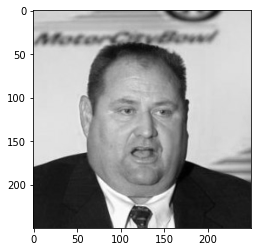

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
# print("Label: %d" % label.numpy())

In [ ]:
image.shape

TensorShape([250, 250, 3])

### PRE PROCESSAMENTO

In [ ]:
IMG_SIZE = 28
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x: (resize_and_rescale(x)), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(BATCH_SIZE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x: (data_augmentation(x, training=True)), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# function to handle ds load
def load_ds_images(dataset, split):
  ds = tfds.load(name=dataset, split=split)
  assert isinstance(ds, tf.data.Dataset)

  ds_images = ds.map(lambda x: x['image'])
  # ds_images = ds.map(lambda x: x)
  return ds_images

In [ ]:
train_ds = prepare(load_ds_images('lfw', 'train'), shuffle=True, augment=False)


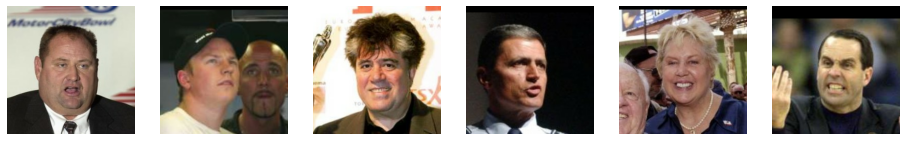

In [ ]:
import matplotlib.pyplot as plt

n_examples_shown = 6
f, axs = plt.subplots(1, n_examples_shown, figsize=(16, 3))

for j, image in enumerate(train_ds.take(n_examples_shown)):
    axs[j].imshow(image.numpy())
    axs[j].axis('off')

#### MODELO VAE

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(28, 28, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 32)   896         ['input_11[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_10[0][0]']              
                                                                                                  
 flatten_5 (Flatten)            (None, 3136)         0           ['conv2d_11[0][0]']              
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_11 (Dense)            (None, 3136)              12544     
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 28, 28, 3)        867 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
# adding earlystopping

stopper = tf.keras.callbacks.EarlyStopping(
    monitor="kl_loss", patience=10, verbose=2
)

In [ ]:
# compile and fit model
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(train_ds, epochs=30, batch_size=128, callbacks=[stopper])

Epoch 1/30
414/414 [==============================] - 35s 80ms/step - loss: 512.4157 - reconstruction_loss: 498.4438 - kl_loss: 2.8885
Epoch 2/30
414/414 [==============================] - 29s 69ms/step - loss: 489.5257 - reconstruction_loss: 484.3807 - kl_loss: 3.4420
Epoch 3/30
414/414 [==============================] - 29s 70ms/step - loss: 485.9401 - reconstruction_loss: 482.0946 - kl_loss: 3.1162
Epoch 4/30
414/414 [==============================] - 28s 67ms/step - loss: 484.8580 - reconstruction_loss: 481.2774 - kl_loss: 2.8728
Epoch 5/30
414/414 [==============================] - 30s 73ms/step - loss: 483.8988 - reconstruction_loss: 480.7337 - kl_loss: 2.8115
Epoch 6/30
414/414 [==============================] - 29s 70ms/step - loss: 483.4931 - reconstruction_loss: 480.5011 - kl_loss: 2.7531
Epoch 7/30
414/414 [==============================] - 29s 69ms/step - loss: 483.6204 - reconstruction_loss: 480.4072 - kl_loss: 2.6933
Epoch 8/30
414/414 [==============================] - 2

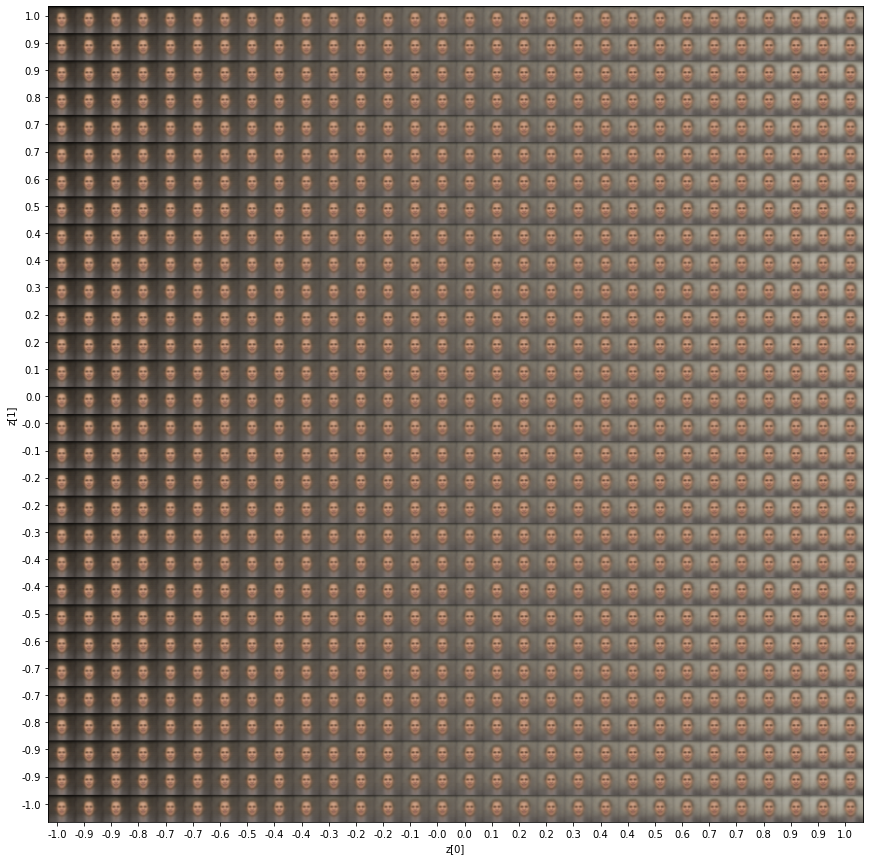

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi, 3]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 3
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)


#### CONCLUSÕES

* Apesar de várias tentativas, a rede parece mostrar a mesma imagem.